In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.animation as animation
%matplotlib ipympl
from scipy.stats import norm
import numpy as np
import torch
import torch.autograd as autograd


## Vanilla Langevin Dynamics 1D

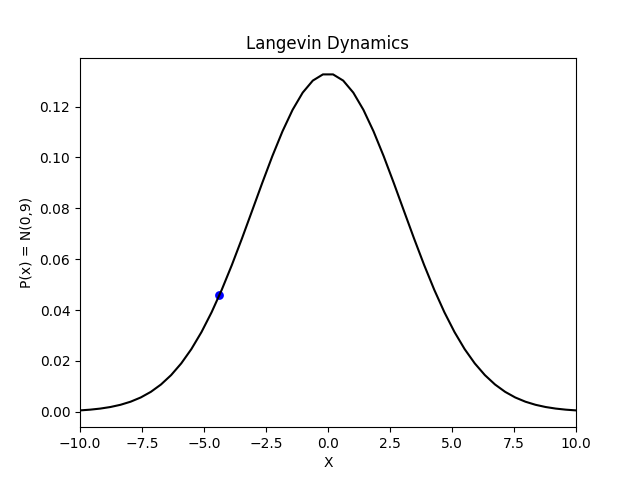

In [3]:
mu = 0
sigma = 3
normal_dist = norm(loc=mu, scale=sigma)

# Normal PDF
def func(x):
    return normal_dist.pdf(x)

def score(x):
    return -(x-mu)/(sigma**2)
    

X_grid = np.linspace(-10,10,50)
L_grid = func(X_grid[:,np.newaxis])


N = 20
alpha = 0.3
X = [random.uniform(-5, 5)]
L = [func(X[0])]
for j in range(N-1):
    x_prev = X[-1]
    eps = random.gauss(0, 1)
    x_new = x_prev + (alpha)*score(x_prev) + math.sqrt(2*alpha)*eps

    X.append(x_new)
    L.append(func(x_new))

fig, ax = plt.subplots()
#plt.clf()
ax.plot(X_grid, L_grid,'k')
ax.scatter(X[0], L[0], s=40, lw=0,label = "X = {}".format(X[0]),c = 'blue')
ax.set_xlim(-10,10)
ax.set_xlabel('X')
ax.set_ylabel(r'P(x) = N(0,9)')
ax.set_title('Langevin Dynamics')

def animate(i):
    ax.annotate('', xy=(X[i+1], L[i+1]), xytext=(X[i], L[i]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    scatter = ax.scatter(X[i+1], L[i+1], s=40, lw=0,label = "X = {}".format(X[i+1]),c = 'blue')

    ax.legend([scatter], [scatter.get_label()],loc = 'upper left')

ani = animation.FuncAnimation(plt.gcf(), animate, frames = N-1,repeat = False, interval=1000)
plt.show()

## Langevin Dynamics with momentum 1D

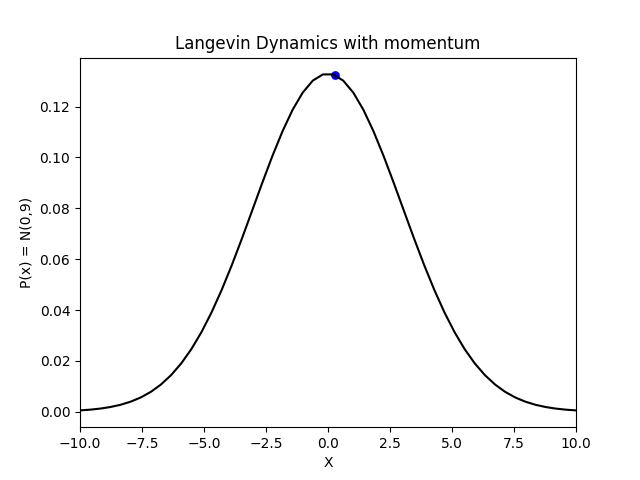

In [4]:
mu = 0
sigma = 3
normal_dist = norm(loc=mu, scale=sigma)

# Normal PDF
def func(x):
    return normal_dist.pdf(x)

def score(x):
    return -(x-mu)/(sigma**2)
    

X_grid = np.linspace(-10,10,50)
L_grid = func(X_grid[:,np.newaxis])


N = 15
alpha = 0.3
gamma = 0.7
X = [random.uniform(-5, 5)]
V = [0]
L = [func(X[0])]
for j in range(N-1):
    x_prev = X[-1]
    Vt = gamma*V[-1] + (alpha)*score(x_prev)

    eps = random.gauss(0, 1)
    x_new = x_prev + Vt + math.sqrt(2*alpha)*eps
    
    V.append(Vt)
    X.append(x_new)
    L.append(func(x_new))


fig, ax = plt.subplots()
#plt.clf()
ax.plot(X_grid, L_grid,'k')
ax.scatter(X[0], L[0], s=40, lw=0,label = "X = {}".format(X[0]),c = 'blue')
ax.set_xlim(-10,10)
ax.set_xlabel('X')
ax.set_ylabel(r'P(x) = N(0,9)')
ax.set_title('Langevin Dynamics with momentum')

def animate(i):
    ax.annotate('', xy=(X[i+1], L[i+1]), xytext=(X[i], L[i]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    scatter = ax.scatter(X[i+1], L[i+1], s=40, lw=0,label = "X = {}".format(X[i+1]),c = 'blue')

    ax.legend([scatter], [scatter.get_label()],loc = 'upper left')

ani = animation.FuncAnimation(plt.gcf(), animate, frames = N-1,repeat = False, interval=1000)
plt.show()

## GMM Langevin Dynamics 1D

In [5]:

class GMMDistAnneal(object):
    def __init__(self, dim):
        self.mix_probs = torch.tensor([0.8, 0.2])
        # self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        # self.mix_probs = torch.tensor([0.1, 0.1, 0.8])
        # self.means = torch.stack([5 * torch.ones(dim), torch.zeros(dim), -torch.ones(dim) * 5], dim=0)
        self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        self.sigma = 1

    def sample(self, n, sigma=1):
        n = n[0]
        mix_idx = torch.multinomial(self.mix_probs, n, replacement=True)
        means = self.means[mix_idx]
        return torch.randn_like(means) * sigma + means


    def log_prob(self, samples, sigma=1):
        logps = []
        for i in range(len(self.mix_probs)):
            logps.append((-((samples - self.means[i]) ** 2).sum(dim=-1) / (2 * sigma ** 2) - 0.5 * np.log(
                2 * np.pi * sigma ** 2)) + self.mix_probs[i].log())
        logp = torch.logsumexp(torch.stack(logps, dim=0), dim=0)
        return logp

    def score(self, samples, sigma=1):
        with torch.enable_grad():
            samples = samples.detach()
            samples.requires_grad_(True)
            log_probs = self.log_prob(samples, sigma).sum()
            return autograd.grad(log_probs, samples)[0]

In [6]:
teacher = GMMDistAnneal(dim=1)

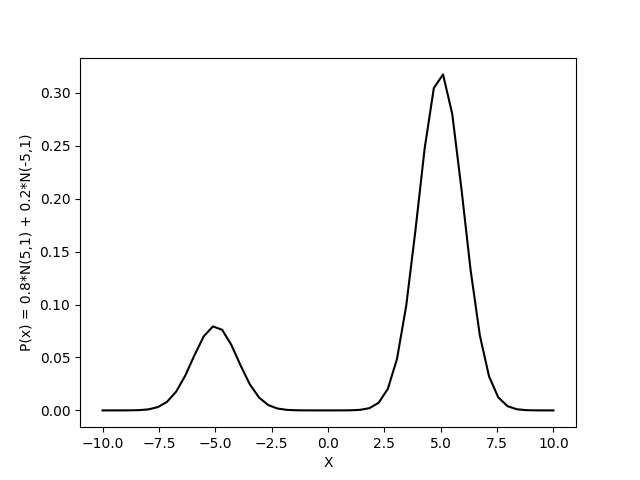

In [7]:
X_grid = np.linspace(-10,10,50)
mesh = torch.from_numpy(X_grid).float()
logp_true = teacher.log_prob(mesh.reshape((-1,1))).exp()
fig,ax = plt.subplots()
ax.plot(X_grid, logp_true,'k')
ax.set_xlabel('X')
ax.set_ylabel(r'P(x) = 0.8*N(5,1) + 0.2*N(-5,1)')
plt.show()

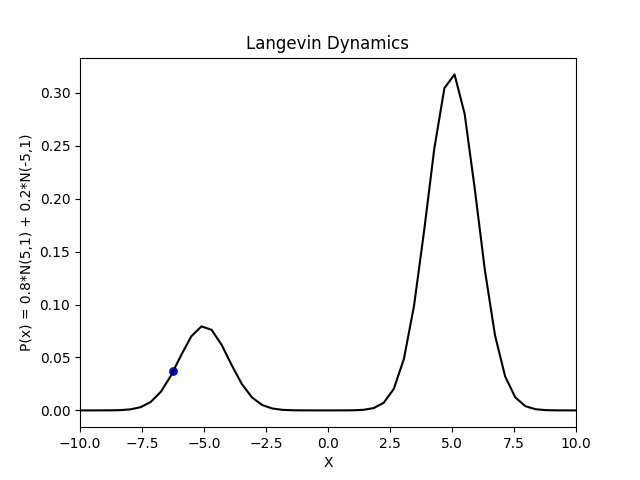

In [8]:
X_grid = np.linspace(-10,10,50)
mesh = torch.from_numpy(X_grid).float()
L_grid = teacher.log_prob(mesh.reshape((-1,1))).exp()


N = 20
alpha = 0.1
X = [random.uniform(-10, 10)]
#X = [-1]
L = [teacher.log_prob(X[0]).exp()]
for j in range(N-1):
    x_prev = X[-1]
    eps = random.gauss(0, 1)
    x_new = x_prev + (alpha)*teacher.score(torch.tensor([x_prev],dtype = torch.float64))[0] + math.sqrt(2*alpha)*eps

    X.append(x_new)
    L.append(teacher.log_prob(x_new).exp())

plt.close()
fig, ax = plt.subplots()
#plt.clf()
ax.plot(X_grid, L_grid,'k')
ax.scatter(X[0], L[0], s=40, lw=0,label = "X = {}".format(X[0]),c = 'blue')
ax.set_xlim(-10,10)
ax.set_xlabel('X')
ax.set_ylabel(r'P(x) = 0.8*N(5,1) + 0.2*N(-5,1)')
ax.set_title('Langevin Dynamics')

def animate(i):
    ax.annotate('', xy=(X[i+1], L[i+1]), xytext=(X[i], L[i]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    scatter = ax.scatter(X[i+1], L[i+1], s=40, lw=0,label = "X = {}".format(X[i+1]),c = 'blue')

    ax.legend([scatter], [scatter.get_label()],loc = 'upper left')

ani = animation.FuncAnimation(plt.gcf(), animate, frames = N-1,repeat = False, interval=1000)
plt.show()

## GMM Annealed Langevin Dynamics 1D

In [9]:
sigmas = np.exp(np.linspace(np.log(5), 0., 10))
sigmas

array([5.        , 4.18125515, 3.49657893, 2.92401774, 2.44521285,
       2.04481177, 1.70997595, 1.42996915, 1.19581317, 1.        ])

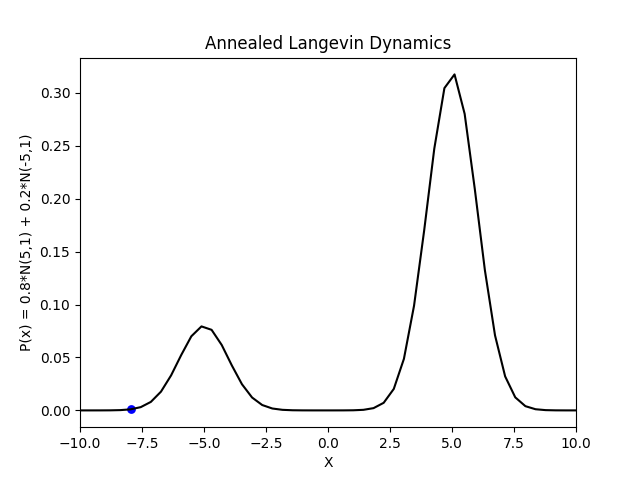

In [10]:
X_grid = np.linspace(-10,10,50)
mesh = torch.from_numpy(X_grid).float()
L_grid = teacher.log_prob(mesh.reshape((-1,1))).exp()



N = 20
lr = 0.1
X = [random.uniform(-10, 10)]
L = [teacher.log_prob(X[0]).exp()]
sigmas = np.exp(np.linspace(np.log(5), 0., 10))

for sigma in sigmas:
    current_lr = lr * (sigma / sigmas[-1]) ** 2
    for j in range(N-1):
        x_prev = X[-1]
        eps = random.gauss(0, 1)
        x_new = x_prev + (current_lr)*teacher.score(torch.tensor([x_prev],dtype = torch.float64),sigma)[0] + math.sqrt(2*current_lr)*eps

        X.append(x_new)
        L.append(teacher.log_prob(x_new).exp())


plt.close()
fig, ax = plt.subplots()
#plt.clf()
ax.plot(X_grid, L_grid,'k')
ax.scatter(X[0], L[0], s=40, lw=0,label = "X = {}".format(X[0]),c = 'blue')
ax.set_xlim(-10,10)
ax.set_xlabel('X')
ax.set_ylabel(r'P(x) = 0.8*N(5,1) + 0.2*N(-5,1)')
ax.set_title('Annealed Langevin Dynamics')

def animate(i):
    ax.annotate('', xy=(X[i+1], L[i+1]), xytext=(X[i], L[i]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    scatter = ax.scatter(X[i+1], L[i+1], s=40, lw=0,label = "X = {}".format(X[i+1]),c = 'blue')

    ax.legend([scatter], [scatter.get_label()],loc = 'upper left')

ani = animation.FuncAnimation(plt.gcf(), animate, frames = N-1,repeat = False, interval=1000)
plt.show()

## GMM Langevin Dynamics 2D

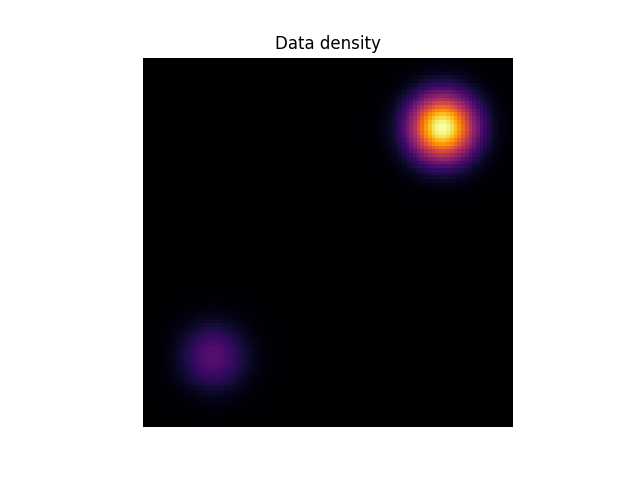

In [11]:
teacher = GMMDistAnneal(dim=2)
mesh = []
grid_size = 100
left_bound=-8
right_bound=8
x = np.linspace(left_bound, right_bound, grid_size)
y = np.linspace(left_bound, right_bound, grid_size)
for i in x:
    for j in y:
        mesh.append(np.asarray([i, j]))
mesh = np.stack(mesh, axis=0)
mesh = torch.from_numpy(mesh).float()

logp_true = teacher.log_prob(mesh)
logp_true = logp_true.view(grid_size, grid_size).exp()

plt.close()
fig,ax1 = plt.subplots()
ax1.grid(False)
ax1.axis('off')
ax1.imshow(np.flipud(logp_true.cpu().numpy()), cmap='inferno')

ax1.set_title('Data density')
plt.show()

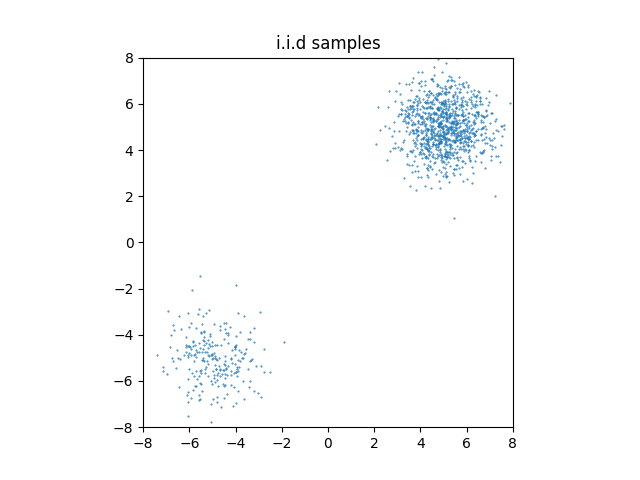

In [12]:
samples = teacher.sample((1280,))
samples = samples.detach().cpu().numpy()

plt.close()
fig,ax2 = plt.subplots()
ax2.scatter(samples[:, 0], samples[:, 1], s=0.2)
ax2.axis('square')
ax2.set_title('i.i.d samples')
ax2.set_xlim([left_bound, right_bound])
ax2.set_ylim([left_bound, right_bound])
plt.show()

In [13]:
def samples_ratio(samples):
    count_left = (samples[:, 0] < 0).sum().item()
    count_right = (samples[:, 0] >= 0).sum().item()

    n = samples.shape[0]
    print("Count of points to the left of (0, 0):", count_left/n)
    print("Count of points to the right of (0, 0):", count_right/n)


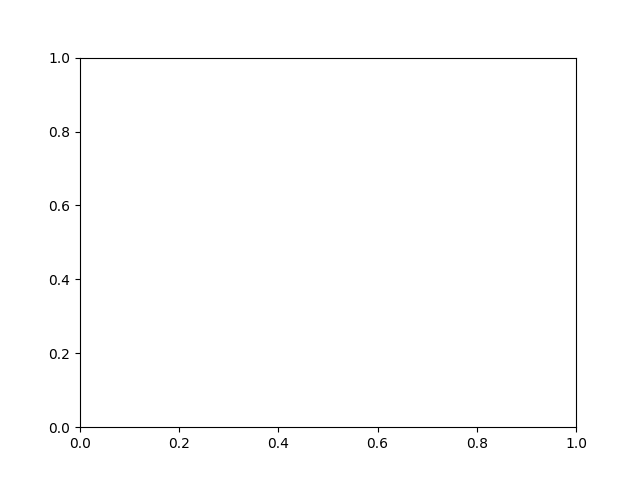

In [14]:
samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
lr = 0.1

plt.close()
fig,ax3 = plt.subplots()


samples_list = [samples]
def plot_till_i(i):
    for j in range(1,i+2):
        ax3.annotate('', xy=(samples_list[j][0,0], samples_list[j][0,1]), xytext=(samples_list[j-1][0,0], samples_list[j-1][0,1]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')


def animate(i):
    ax3.cla()
    ax3.axis('square')
    ax3.set_title('Langevin dynamics samples')
    ax3.set_xlim([left_bound, right_bound])
    ax3.set_ylim([left_bound, right_bound])
    current_lr = lr
    init = samples_list[-1]
    init = init + current_lr / 2 * teacher.score(init).detach()
    init = init + torch.randn_like(init) * np.sqrt(current_lr)

    samples_list.append(init)
    ax3.scatter(init[:, 0], init[:, 1], s=0.2)
    plot_till_i(i)
    
    

ani = animation.FuncAnimation(plt.gcf(), animate, frames = 100,repeat = False, interval=10)
plt.show()

In [15]:
def plot_likelihood(teacher,samples_list):
    plt.close()
    fig,ax = plt.subplots()
    likelihood = [teacher.log_prob(samples[0]) for samples in samples_list]
    ax.plot(range(len(likelihood)),likelihood)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Likelihood')
    ax.set_title('Likelihood over iterations')

    plt.show()

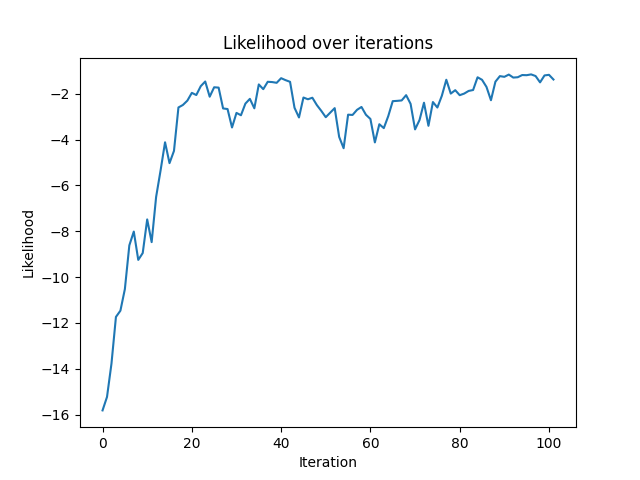

In [16]:
plot_likelihood(teacher,samples_list)

In [17]:
samples_ratio(samples_list[-1])

Count of points to the left of (0, 0): 0.51875
Count of points to the right of (0, 0): 0.48125


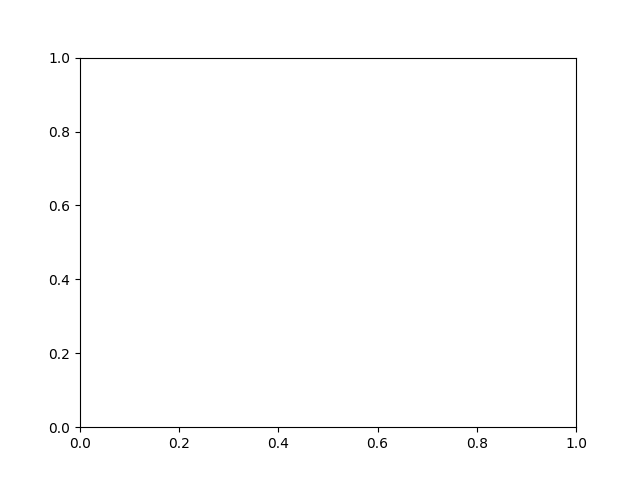

In [18]:
samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
lr = 0.1
gamma = 0.7
V = [0]
samples_list = [samples]

plt.close()
fig,ax3 = plt.subplots()


def plot_till_i(i):
    for j in range(1,i+1):
        ax3.annotate('', xy=(samples_list[j][0,0], samples_list[j][0,1]), xytext=(samples_list[j-1][0,0], samples_list[j-1][0,1]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')


def animate(i):
    ax3.cla()
    ax3.axis('square')
    ax3.set_title('Langevin dynamics with momentum')
    ax3.set_xlim([left_bound, right_bound])
    ax3.set_ylim([left_bound, right_bound])
    current_lr = lr
    init = samples_list[-1]

    Vt = gamma*V[-1] + current_lr / 2 * teacher.score(init).detach()
    init = init + Vt
    init = init + torch.randn_like(init) * np.sqrt(current_lr)

    V.append(Vt)
    samples_list.append(init)
    ax3.scatter(init[:, 0], init[:, 1], s=0.2)
    plot_till_i(i)
    
    

ani = animation.FuncAnimation(plt.gcf(), animate, frames = 10,repeat = False, interval=100)
plt.show()

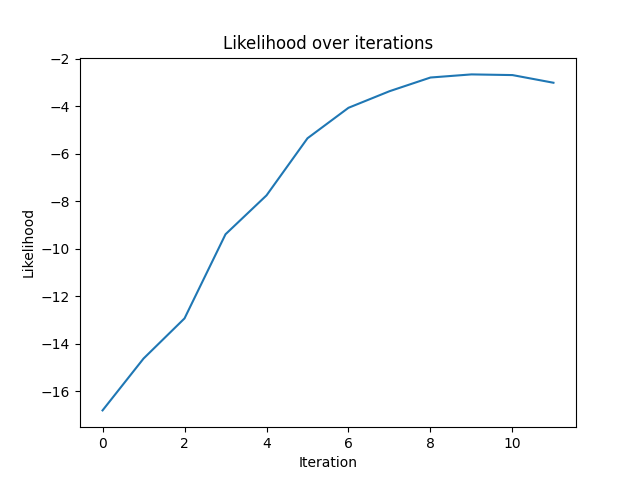

In [19]:
plot_likelihood(teacher,samples_list)

In [20]:
samples_ratio(samples_list[-1])

Count of points to the left of (0, 0): 0.46328125
Count of points to the right of (0, 0): 0.53671875


### Mixing coefficients are not given preference in Langevin dynamics

## GMM Annealed Langevin Dynamics 2D

In [21]:
np.exp(np.linspace(np.log(20), 0, 10))

array([20.        , 14.33742329, 10.27808533,  7.368063  ,  5.2819519 ,
        3.78647901,  2.71441762,  1.94588772,  1.39495079,  1.        ])

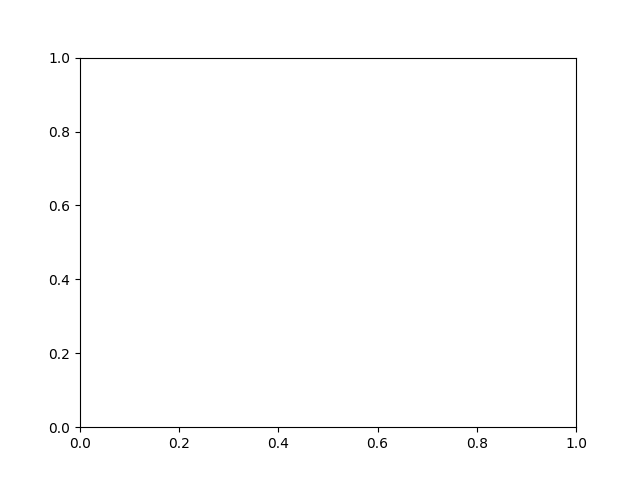

In [22]:
samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
lr = 0.1

plt.close()
fig,ax3 = plt.subplots()


samples_list = [samples]
sigmas = np.exp(np.linspace(np.log(20), 0, 10))
n_steps_each = 10

def plot_last(i,k):
    for j in range(max(i-k,1),i+2):
        ax3.annotate('', xy=(samples_list[j][0,0], samples_list[j][0,1]), xytext=(samples_list[j-1][0,0], samples_list[j-1][0,1]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
 
def animate(i):
    ax3.cla()
    ax3.axis('square')
    ax3.set_title('Annealed Langevin dynamics samples')
    ax3.set_xlim([left_bound, right_bound])
    ax3.set_ylim([left_bound, right_bound])
    
    sigma = sigmas[i//n_steps_each]
    current_lr = lr * (sigma / sigmas[-1]) ** 2
    init = samples_list[-1]
    init = init + current_lr / 2 * teacher.score(init,sigma).detach()
    init = init + torch.randn_like(init) * np.sqrt(current_lr)

    samples_list.append(init)
    sigma = format(sigma, ".2f")
    scatter = ax3.scatter(init[:, 0], init[:, 1], s=0.2,label = "sigma = {}".format(sigma))

    ax3.legend([scatter], [scatter.get_label()],loc = 'upper left')
    plot_last(i,20)
    

ani = animation.FuncAnimation(plt.gcf(), animate, frames = 100,repeat = False, interval=0.01)
plt.show()

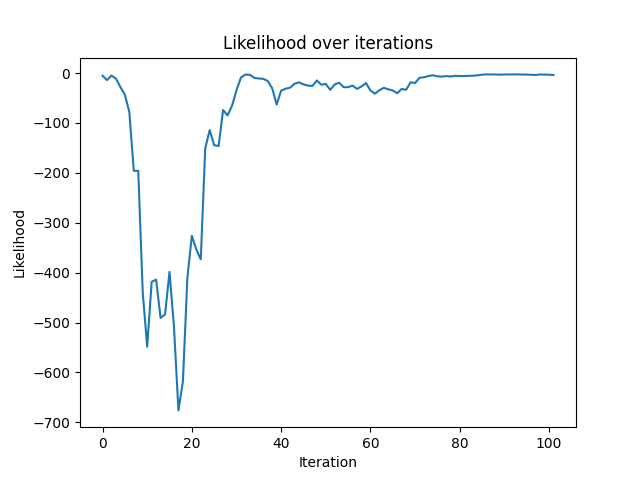

In [23]:
plot_likelihood(teacher,samples_list)

In [24]:
samples_ratio(samples_list[-1])

Count of points to the left of (0, 0): 0.315625
Count of points to the right of (0, 0): 0.684375


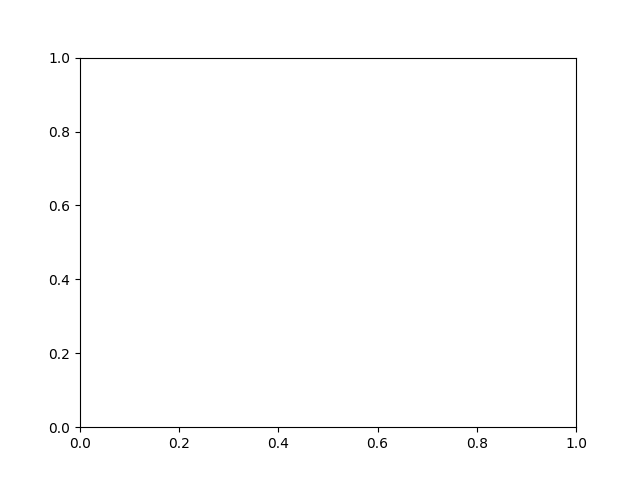

In [38]:
samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
lr = 0.3
gamma = 0.5

plt.close()
fig,ax3 = plt.subplots()


samples_list = [samples]
sigmas = np.exp(np.linspace(np.log(20), 0, 10))
n_steps_each = 3
V = [0]
def animate(i):
    ax3.cla()
    ax3.axis('square')
    ax3.set_title('Annealed Langevin dynamics with momentum samples')
    ax3.set_xlim([left_bound, right_bound])
    ax3.set_ylim([left_bound, right_bound])
    
    sigma = sigmas[i//n_steps_each]
    current_lr = lr * (sigma / sigmas[-1]) ** 2
    
    init = samples_list[-1]
    Vt = gamma*V[-1] + current_lr / 2 * teacher.score(init,sigma).detach()
    init = init + Vt
    init = init + torch.randn_like(init) * np.sqrt(current_lr)

    V.append(Vt)
    samples_list.append(init)
    sigma = format(sigma, ".2f")
    scatter = ax3.scatter(init[:, 0], init[:, 1], s=0.2,label = "sigma = {}".format(sigma))

    ax3.legend([scatter], [scatter.get_label()],loc = 'upper left')
    plot_last(i,30)
    

ani = animation.FuncAnimation(plt.gcf(), animate, frames = 30,repeat = False, interval=10)
plt.show()

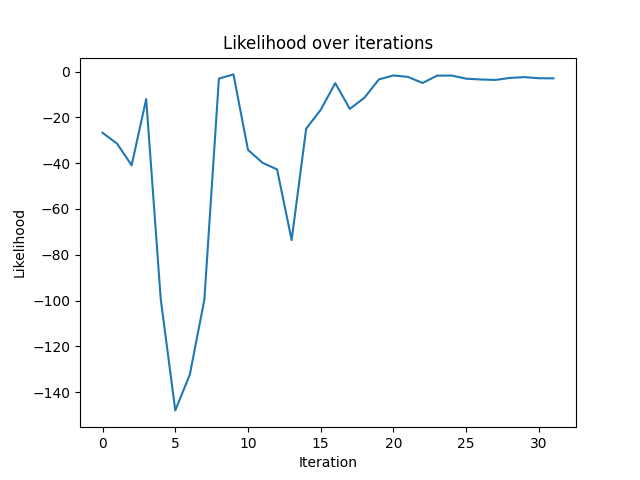

In [39]:
plot_likelihood(teacher,samples_list)

In [40]:
samples_ratio(samples_list[-1])

Count of points to the left of (0, 0): 0.1796875
Count of points to the right of (0, 0): 0.8203125
